# Проект по Анализу Данных
### Выполнил студент группы БЭК223 Амиров Марат

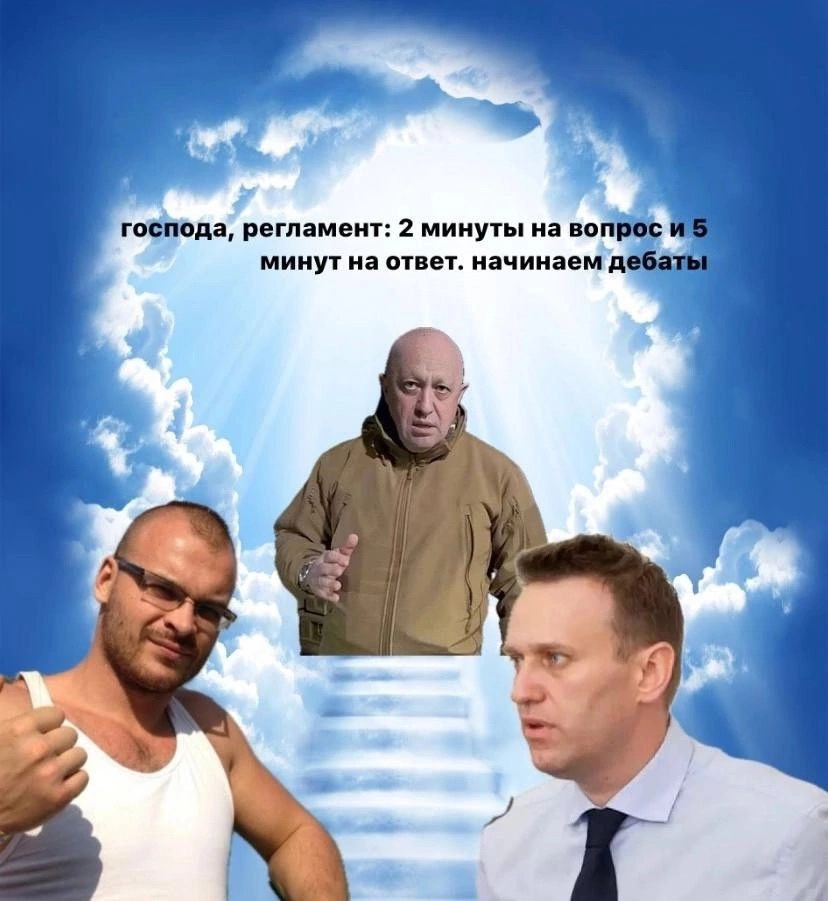

Позволю начать себе с совсем небольшого предисловия: изначально идея моего проекта была в проверки гипотезы, что посты со словами 'Путин', 'Президент' и тд. намного популярнее среднестатистического поста в государственных СМИ (на примере группы ВК 'РИА Новости'). Но потом я подумал, что строить предсказательную модель по таким параметрам будет тяжело и задачу поставлена слишком узко, поэтому я решил, что во время Eda мной будут рассмотрены топ-100 самых популярных имен собственных в постах (или слов с большой буквы), а во время пострения предсказательной модели мы рассмотрим влияние всех токенов с собственными именами на итоговую успешность поста.

Начнем, для начала мы подключимся к VK API и создадим сессию, используя ключ client_secret, который мне дал семинарист.



In [ ]:
import vk_api
def auth_handler():
    key = input("Authentication code: ")
    return key, False
login = ''
password = ''
vk_session = vk_api.VkApi(login, password, auth_handler=auth_handler, app_id=6287487, client_secret="QbYic1K3lEV5kTGiqlq2")
vk_session.auth()
vk = vk_session.get_api()

После этого мы спарсим всю стену сообщества 'РИА новости', использую интрументы get_all и айди необходимой нам группы, который мы получили из веб-ссылки на сообщество. Думаю, что для содания репрезентативной выборки мне понадобится минимум 5000 постов, так как посты очень разные и по содрежанию и по их популярности.

In [ ]:
tools = vk_api.VkTools(vk)
wall_id = -15755094
wall = tools.get_all('wall.get', 4, {'owner_id': wall_id}, limit = 5000)

На следующем этапе мы создадим Data Frame с нашими данными, для каждого поста нам понадобятся: количество лайков, просмотров, репостов, комментариев и его текст. Думаю, этих данных, как ключевых, будет достаточно. Также уберем посты с пустым текстовым полем и посты, в которых в тексте присутствуют только эмодзи (в нашем случае - молнии). Два поста (45432794 и 44731519) пришлось убрать вручную, так как при их парсинге воpникали непредвиденные ошибки. Столбец с датой переведем из экспоненицального формата в обычный, выведем медиану и среднее для количества лайков.

In [ ]:
import pandas as pd
df = pd.DataFrame()
df.index = [post['id'] for post in wall['items']]
df['date'] = [post['date'] for post in wall['items']]
df['date'] = pd.to_datetime(df['date'], unit='s')
df['date'] = df['date'].dt.date
col = ['likes', 'reposts', 'comments', 'views']
for c in col:
  df[c] = [post[c]['count'] for post in wall['items']]
df['text'] = [post['text'] for post in wall['items']]
df = df.loc[df['text'] != '⚡⚡⚡']
df = df.loc[df['text'] != '']
df=df.dropna()
df = df.drop(index=45432794)
df = df.drop(index=44731519)
df['likes'].median(), df['likes'].mean()


(338.0, 567.9375158107766)

In [ ]:
df

,date,likes,reposts,comments,views,text
45491021,2024-05-12,206,3,103,32187,Историческая справедливость будет восстановлен...
45490775,2024-05-12,256,37,79,48811,UPD: двух погибших достали из-под завалов дома...
45490122,2024-05-12,218,13,48,42931,44 года назад на экраны вышел советский фильм-...
45489844,2024-05-12,849,23,103,58092,"Российские военнослужащие освободили Гатище, К..."
45489449,2024-05-12,1005,143,252,176869,При обрушении подъезда в многоэтажке в Белгоро...
...,...,...,...,...,...,...
44469453,2024-01-03,255,17,66,103879,Эпицентр землетрясения залегал на глубине деся...
44469316,2024-01-03,419,9,75,94526,"""Россия — страна, обладающая опытом в организа..."
44469239,2024-01-03,449,21,120,146012,"""За последние пять суток <…> по Украине выпуст..."
44468704,2024-01-02,454,19,55,104496,"""По информации от спасательной службы Севастоп..."


Создадим две новые переменные: активность и популярность, которые показывают, какой процент людей лайкнул пост, который просмотрел и на сколько сильно каждый пост отличается от медианы по лайкам (будет принимать, что если пост популярнее половины всех постов, то он 'Популярен'). Столбцы 'reposts' и 'comments' оставим без изменений, думаю, что в будущем мы будем обучать несколько регрессий и будем добавлять эти признаки (предварительно обработав), смотря как изменилось точность нашего прогноза.

In [ ]:
df['Popularity']=df['likes']/df['likes'].median()
df['Activity']=df['likes']/df['views']

Давайте перейдем к созданию нашего таргета: отнормируем столбцы 'Popularity' и 'Activity' и создадим столбец с их суммой, делая ставку на то, что для новостного издания важно, чтобы пост был одинаково и популярен и при этом чтобы аудитория на нем была достаточно активной.


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Popularity', 'Activity']] = scaler.fit_transform(df[['Popularity', 'Activity']])
df['Success_Rate'] = df['Popularity']+df['Activity']
df.head()

,date,likes,reposts,comments,views,text,Popularity,Activity,Success_Rate
45491021,2024-05-12,206,3,103,32187,Историческая справедливость будет восстановлен...,-0.386047,0.351527,-0.034521
45490775,2024-05-12,256,37,79,48811,UPD: двух погибших достали из-под завалов дома...,-0.332717,0.044351,-0.288365
45490122,2024-05-12,218,13,48,42931,44 года назад на экраны вышел советский фильм-...,-0.373248,0.000004,-0.373244
45489844,2024-05-12,849,23,103,58092,"Российские военнослужащие освободили Гатище, К...",0.299785,2.535517,2.835302
45489449,2024-05-12,1005,143,252,176869,При обрушении подъезда в многоэтажке в Белгоро...,0.466176,0.160654,0.626831


Присвоим таргету категориальные значения: пост успешный (1), если его таргет больше 1, он обычный (0), если его таргет от -1 до 1 и он непопулярный если таргет меньше -1. Проверим сбалансированность классов и увидим, что большинство постов - обычные, а непопулярных постов в два раза больше, чем популярных, что в целом, логично. Кстати, думаю очевидно, но скажу, что все остальные признаки кроме 'text' и 'target' являются числовыми.


In [ ]:
df['Target'] = df['Success_Rate'].apply(lambda x: -1 if x < -1 else (1 if x > 1 else 0))
df['Target'].value_counts()


Target
 0    2096
-1    1178
 1     679
Name: count, dtype: int64

Далее напишем функцию custom_tokenizer, которая будет обрабатывать текст и выдавать список имен собственных првиеденных к основной части слова (без приставок и сууффиксов). Опишу процесс его работы:
1. Делим текст, удаля стоп-слова и пунктуацию.
2. Удаляем все эмодзи и оставляем только токены, которые начинаются с большой буквы.
3. Применяем SnowBallStemmer для обрезки слов до основных частей.
4. Убираем токен 'росс', потому что он является выбросом, так как слово Россия встречается почти в каждом посте.

Ниже пример его работы.

In [ ]:
import nltk
import numpy as np
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from string import punctuation
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
punctuation = list(string.punctuation)
nltk.download('stopwords')
stop_words = stopwords.words('russian')

def custom_tokenizer(text):
  vectorizer = CountVectorizer(lowercase=False, stop_words=stop_words+punctuation)
  X_train_counts = vectorizer.fit_transform([text])
  vocaby = vectorizer.get_feature_names_out()
  token_counts = np.array(X_train_counts.sum(axis=0)).ravel()
  filtered_vocab = []
  filtered_token_counts = []
  tokensy=[]
  tokensy1=[]
  for idx, token in enumerate(vocaby):
      if not (len(token)==1 and ord(token) >= 128) and not (token.isalpha()==True and token.lower() in stop_words) and token[0].isupper()==True:
          filtered_vocab.append(token)
          filtered_token_counts.append(token_counts[idx])
  filtered_token_counts = np.array(filtered_token_counts)
  sorted_indices_descending = np.argsort(filtered_token_counts)[::-1]
  for idx in sorted_indices_descending:
    tokensy.append(filtered_vocab[idx])
  tokensy = [stemmer.stem(w) for w in tokensy]
  for t in tokensy:
    if t!='росс':
      tokensy1.append(t)
  return tokensy1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['text'].iloc[0]

'Историческая справедливость будет восстановлена, для этого все русские города необходимо освободить в рамках спецоперации, уверен глава Донецкой Народной Республики Денис Пушилин. В нашем интервью он рассказал о ежедневном продвижении российских военнослужащих на фронте, ситуации на самом горячем направлении — в районе Часова Яра, о военных преступлениях ВСУ против мирного населения, а также о восстановлении Авдеевки и перспективе мирных переговоров с Киевом.'

In [ ]:
df['Tokens']=df['text'].apply(custom_tokenizer)
custom_tokenizer(df['text'].iloc[0])


['яр',
 'часов',
 'республик',
 'пушилин',
 'народн',
 'киев',
 'историческ',
 'донецк',
 'денис',
 'всу',
 'авдеевк']

Теперь выведем топ-100 самых популярных имен собственных по количеству встреч по всей странице. Заметим, что самыми популярными именами собственными являются сокращения от названий других стран, но будет ли это говорить об их связи с таргетом? Чуть позже узнаем.

In [ ]:
cv = CountVectorizer(tokenizer=custom_tokenizer, lowercase=False)
X = cv.fit_transform(df['text'])
vocab = cv.get_feature_names_out()
token_counts = np.array(X.sum(axis=0)).ravel()
sorted_indices_descending = np.argsort(token_counts)[::-1]
top_tokens_descending = [(vocab[idx], token_counts[idx]) for idx in sorted_indices_descending[:100]]
for token, count in top_tokens_descending:
    print(f"{token}: {count}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


украин: 623
сша: 385
путин: 330
москв: 284
всу: 281
ри: 192
новост: 190
киев: 188
эт: 179
владимир: 175
российск: 170
крокус: 144
мид: 143
зеленск: 125
нат: 124
запад: 123
сво: 118
такж: 107
вашингтон: 104
ес: 99
прямаятрансляц: 96
миноборон: 92
сми: 89
израил: 86
герман: 85
сегодн: 85
европ: 78
президент: 78
байд: 75
александр: 74
мчс: 72
франц: 70
пво: 65
однак: 63
серг: 63
кром: 62
украинск: 61
днр: 59
глав: 59
побед: 58
евросоюз: 57
оон: 57
петербург: 57
белгородск: 56
польш: 55
великобритан: 53
госдум: 52
газ: 51
нов: 50
международн: 50
макрон: 49
захаров: 49
крым: 48
трамп: 48
сит: 48
бел: 48
авдеевк: 47
карлсон: 47
молдав: 46
ки: 46
жител: 44
холл: 44
пентагон: 44
так: 43
белгород: 43
цик: 43
дмитр: 43
подробн: 42
кита: 42
песк: 42
суд: 41
венгр: 41
ран: 41
турц: 40
париж: 39
белорусс: 38
запорожск: 38
велик: 37
брюссел: 37
красн: 36
воен: 35
отечествен: 35
мужчин: 34
власт: 34
такер: 34
донецк: 34
бпла: 33
американск: 33
перв: 33
местн: 32
фрг: 32
мвд: 32
реч: 32
херсонск: 32
T

Выведем попарный график и увидим, что сильных связей на нем не наблюдается, кроме тех, которые мы сами и сделали во время создания целевой переменной. Интересно, что зависимость между популярностью и таргетом более пологая, чем зависимость между таргетом и активностью, это значит, что многие посты становятся успешнее за счет высокой популярности, но не активности.

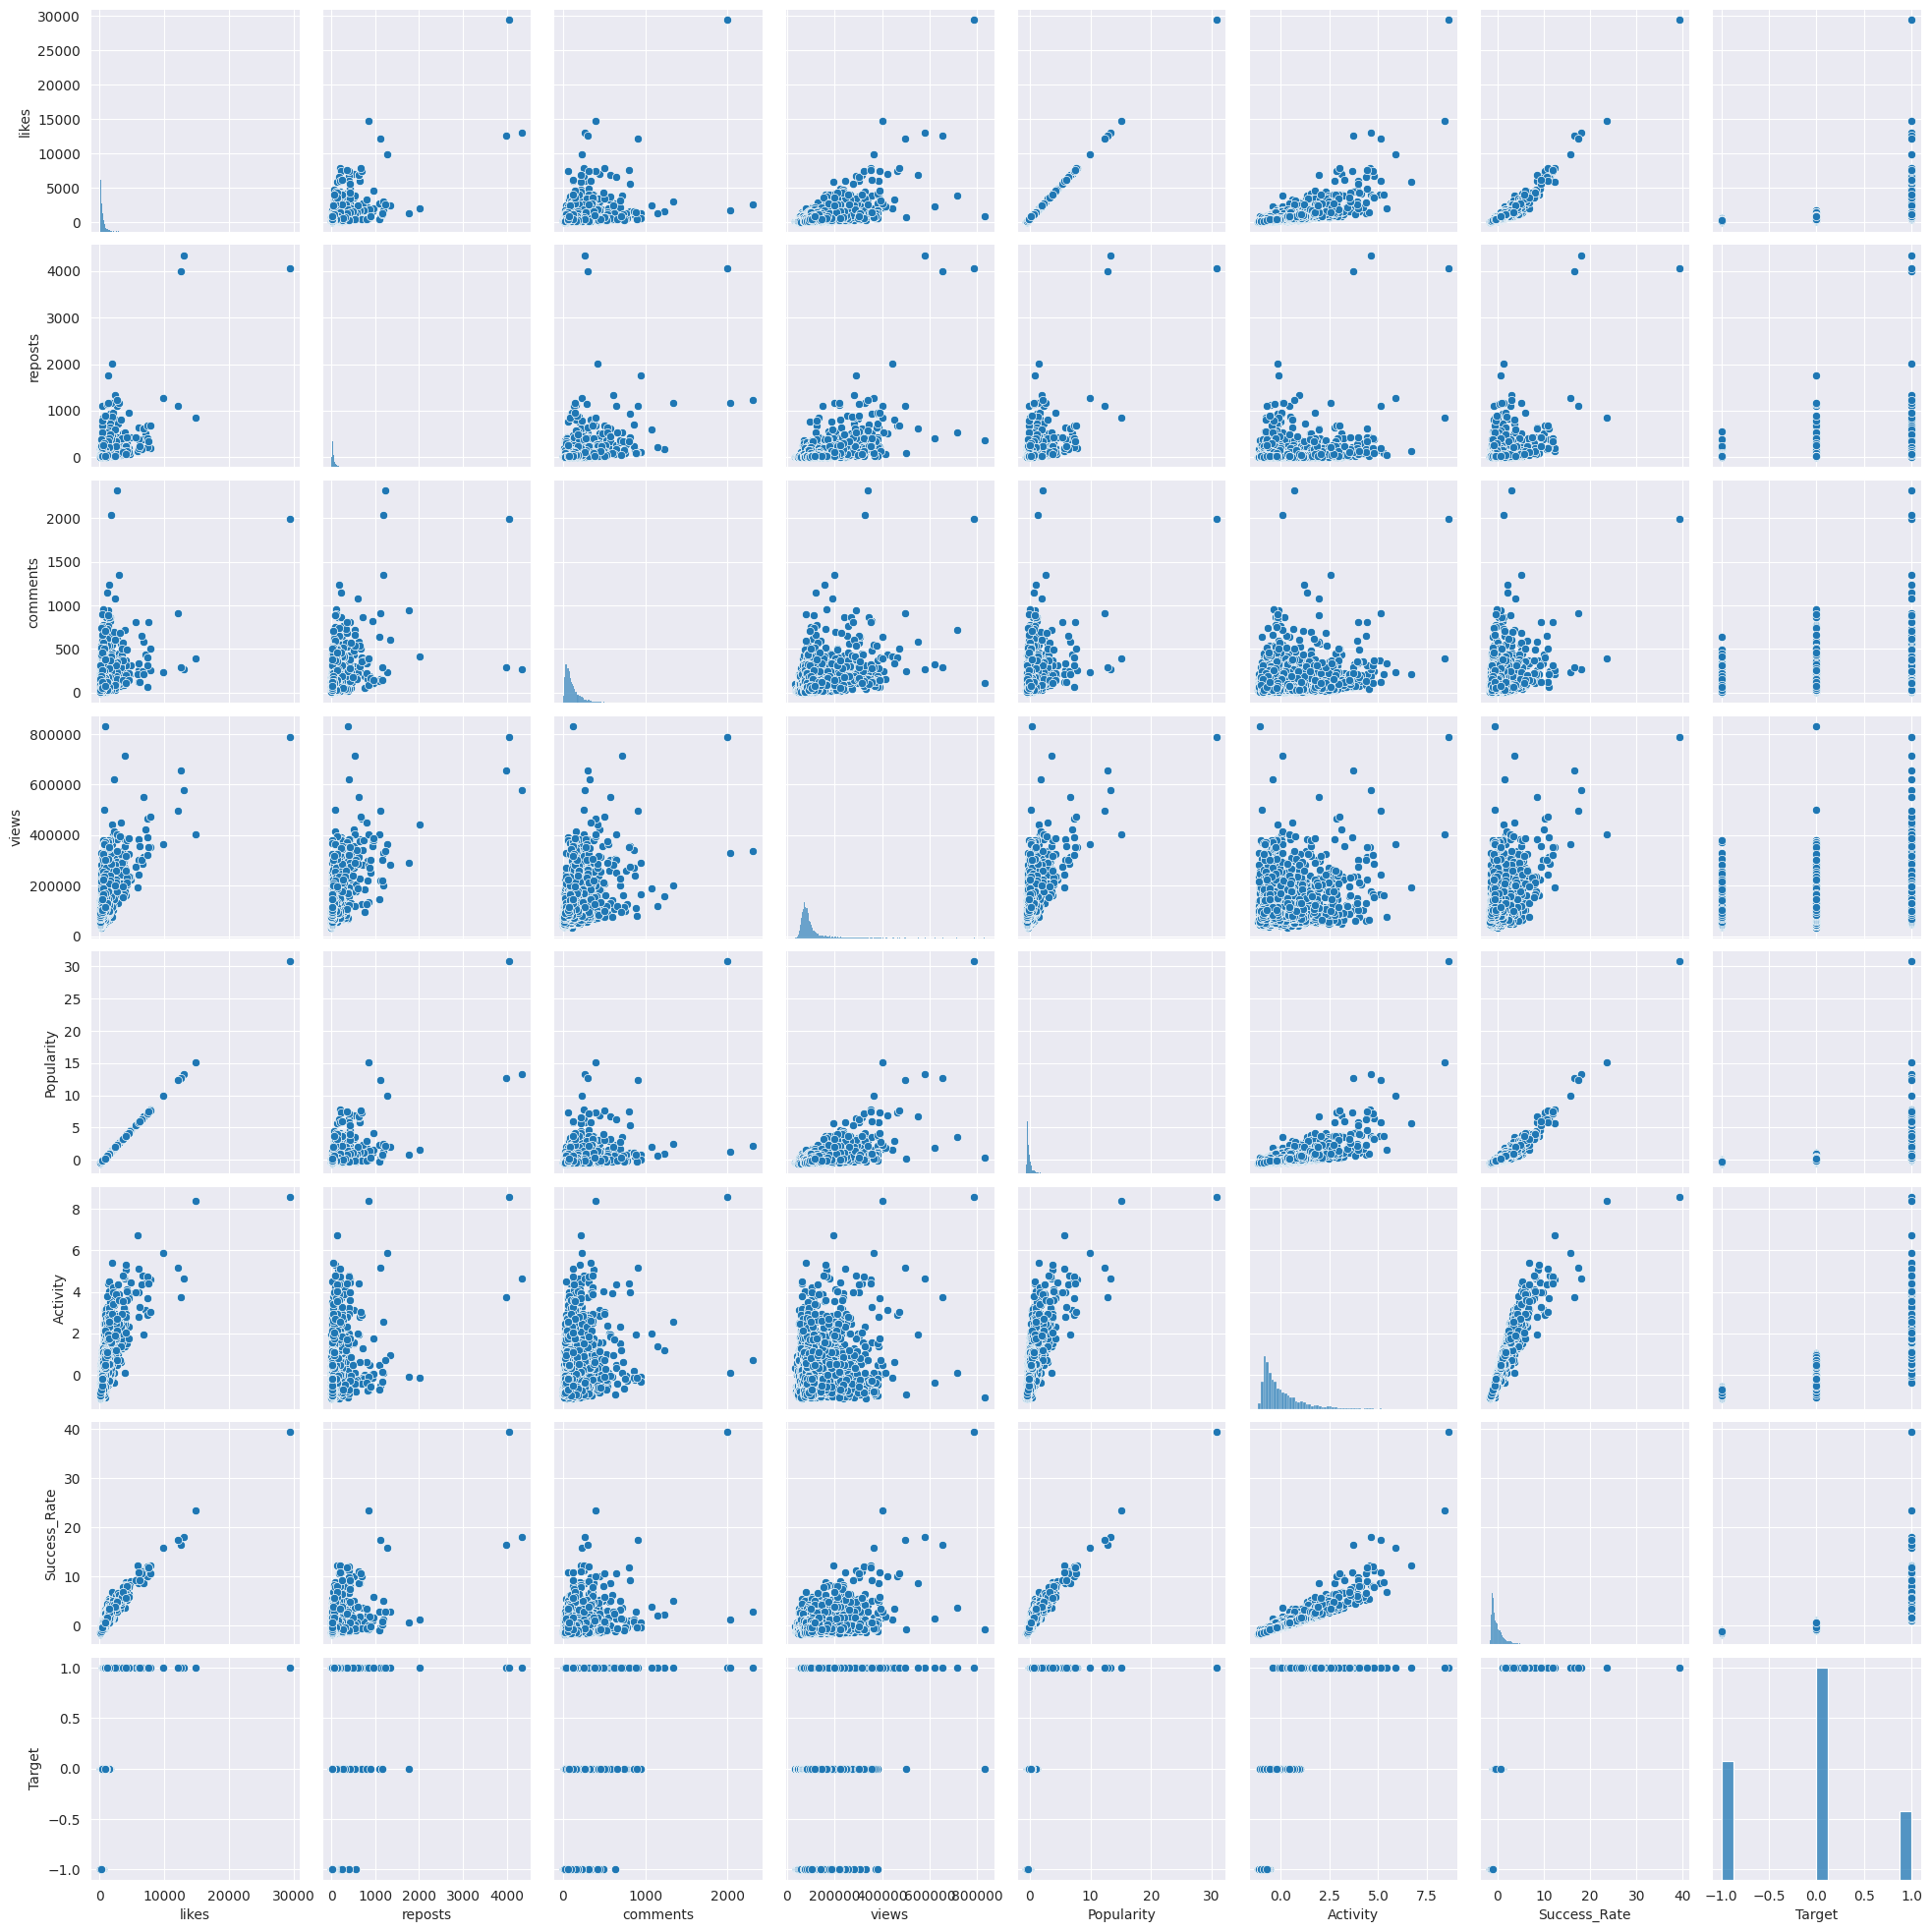

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
sns.pairplot(df);

Теперь было бы интересно посмотреть, сколько в среднем лайков приходится на каждый токен из топ-100. Для этого мы собираем сумму лайков для каждого токена и количество его упоминаний, а затем считаем среднее. Оказалось, что лидирует интересный токен -  'мужчин', что же это значит? На самом деле ничего, просто новости зачастую начинаются с этого слова и несут информацию либо сугубо отрицательного характера (Мужчина убил 500 детей) или положительного (Мужчину наградили звездой почета), что делает эти посты популярнее.

P.S. Из интереса я проверил популярность токена 'женщин', оказалось, что он включается чуть меньшее количество раз, но очень редко начинается с большой буквы, что исключает его из списка наших токенов.

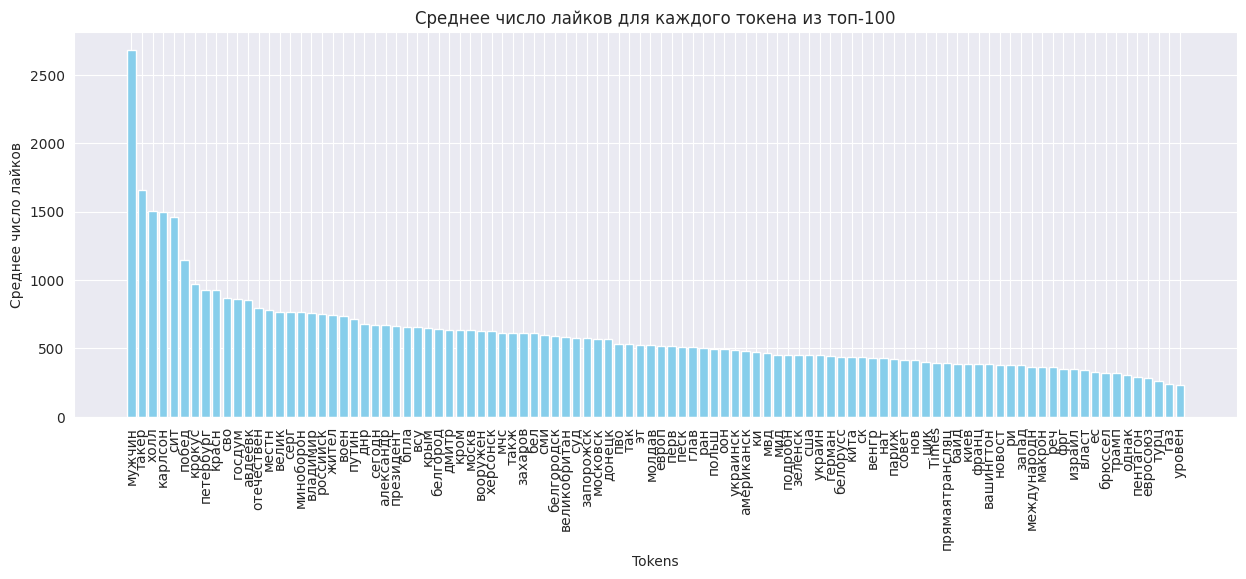

In [ ]:
import matplotlib.pyplot as plt
names100=[]
for i in top_tokens_descending:
  names100.append(i[0])
likes_sum = {token: 0 for token in names100}
counts = {token: 0 for token in names100}
for index, row in df.iterrows():
    tokens = row['Tokens']
    for token in tokens:
        if token in names100:
            likes_sum[token] += row['likes']
            counts[token] += 1
average_likes = {token: (likes_sum[token] / counts[token]) for token in names100}
sorted_tokens = sorted(average_likes, key=average_likes.get, reverse=True)
sorted_likes = [average_likes[token] for token in sorted_tokens]

plt.figure(figsize=(15, 5))
plt.bar(sorted_tokens, sorted_likes, color='skyblue')
plt.xlabel('Tokens')
plt.ylabel('Среднее число лайков')
plt.title('Среднее число лайков для каждого токена из топ-100')
plt.xticks(rotation=90)
plt.show()

Далее было бы интересно посмотреть на то, как инфоповоды влияют и на количество лайков по токенам и сколько в среднем каждый инфоповод удерживает лидерство, для этого мы можем посчитать самые 'залайканные' токены с начала нашего года по неделям. Видно, что наибольшую активность люди проявляли в марте, во время трагедии в 'Крокусе', второй по популярности инфоповод - праздник 9 мая, во все остальные недели самым популярным токеном были 'путин', 'украин' и 'сша'. Еще можно заметить, что каждый из токенов не держал лидерство более двух недель. Ниже продублирован график самого популярного токена из топ-100 для каждого дня.

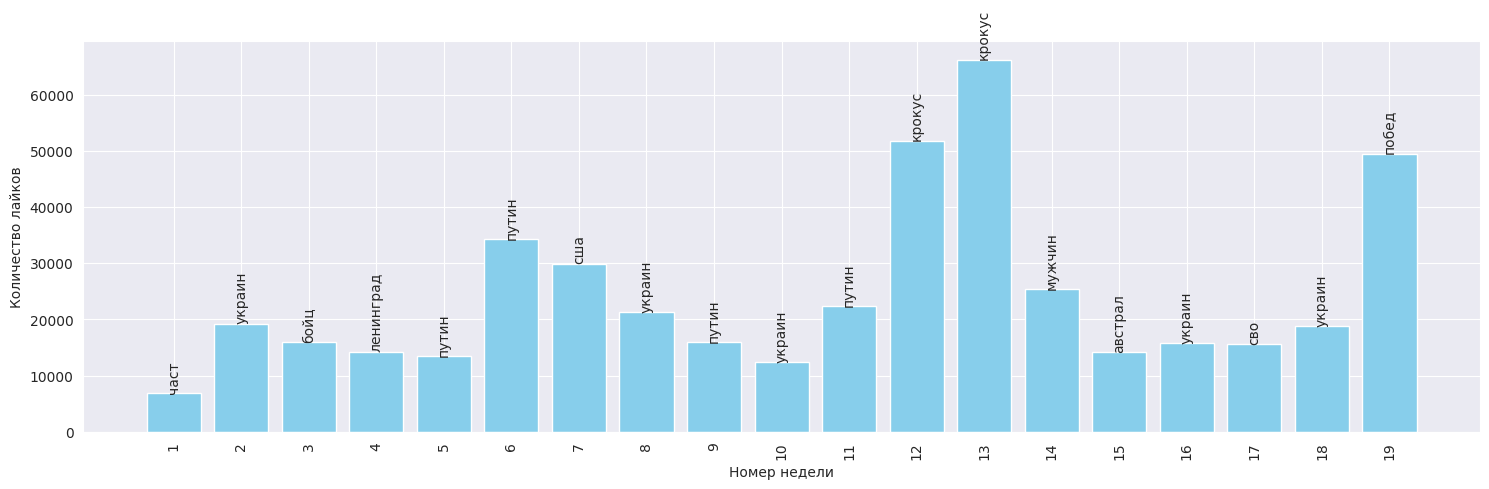

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.isocalendar().week

weekly_token_likes = df.explode('Tokens').groupby(['week', 'Tokens'])['likes'].sum().reset_index()
most_liked_tokens = weekly_token_likes.loc[weekly_token_likes.groupby('week')['likes'].idxmax()]

plt.figure(figsize=(15, 5))
bars = plt.bar(x=most_liked_tokens['week'].astype(str), height=most_liked_tokens['likes'], color='skyblue')
for bar, token in zip(bars, most_liked_tokens['Tokens']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, token, ha='center', va='bottom', rotation=90)

plt.xlabel('Номер недели')
plt.ylabel('Количество лайков')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

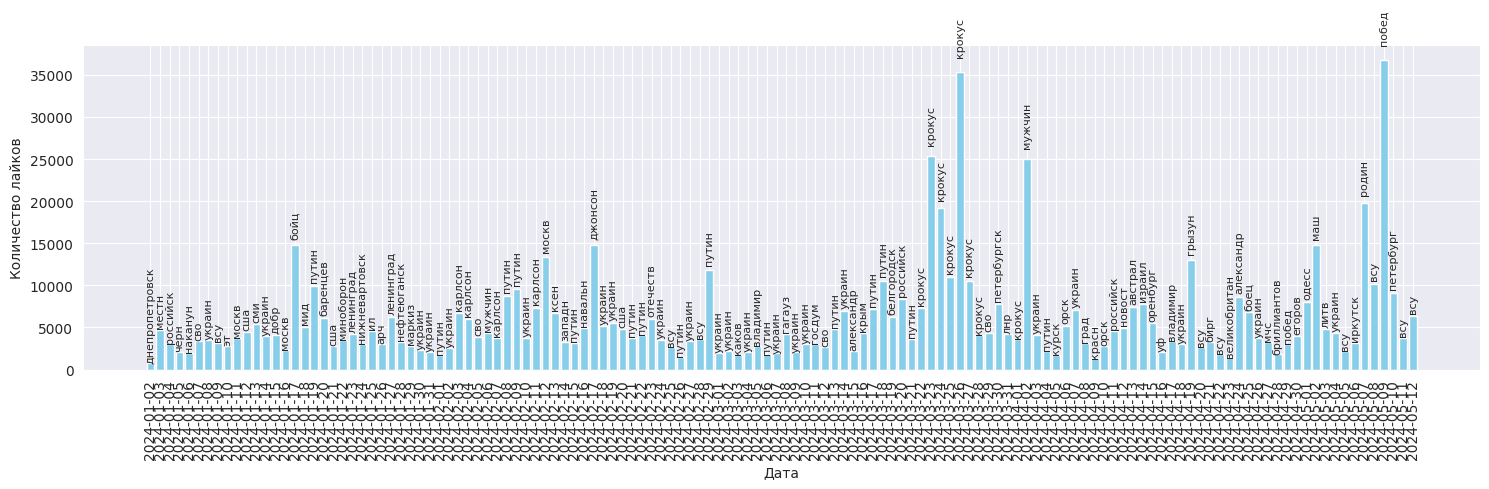

In [ ]:
df['date'] = pd.to_datetime(df['date'])
daily_token_likes = df.explode('Tokens').groupby(['date', 'Tokens'])['likes'].sum().reset_index()
most_liked_tokens_daily = daily_token_likes.loc[daily_token_likes.groupby('date')['likes'].idxmax()]
plt.figure(figsize=(15, 5))
bars = plt.bar(x=most_liked_tokens_daily['date'].dt.strftime('%Y-%m-%d'), height=most_liked_tokens_daily['likes'], color='skyblue')
for bar, token in zip(bars, most_liked_tokens_daily['Tokens']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05 * yval, token, ha='center', va='bottom', rotation=90, fontsize=8)
plt.xlabel('Дата')
plt.ylabel('Количество лайков')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

А теперь посмотрим на то, какое среднее значение таргета наблюдается для каждого из топ-100 токенов. Видно, что для большинства из них оно по модулю меньше 0.4, но есть токены, которые чаще встречаются в успешных постах, такие как 'такер', 'сво', 'путин', 'отечественн'. А есть безуспешные токены: 'израил', 'турц', 'газ', 'уровен'. Интересено, что почти все названия иностранных государств тут находятся в отрицательной зоне.

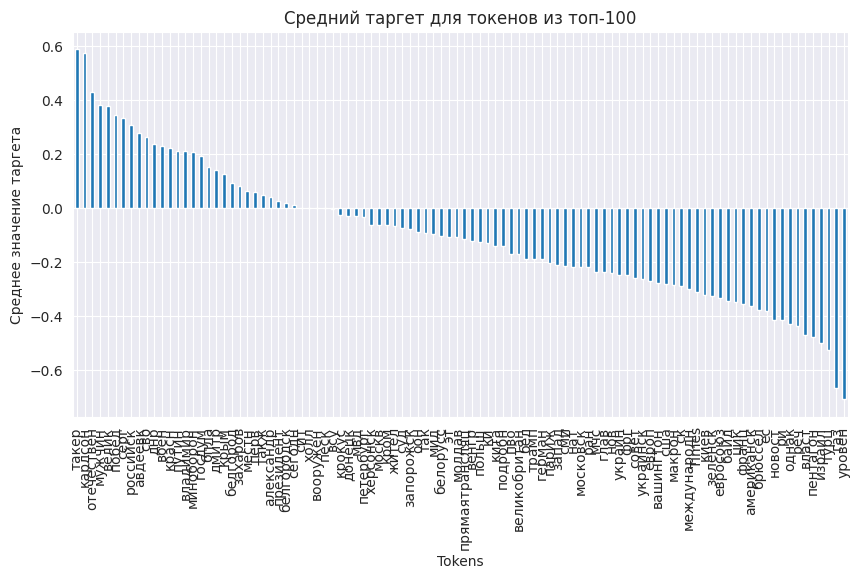

In [ ]:
exploded_df = df.explode('Tokens')
filtered_df = exploded_df[exploded_df['Tokens'].isin(names100)]
average_likes = filtered_df.groupby('Tokens')['Target'].mean()
average_likes.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
plt.xlabel('Tokens')
plt.ylabel('Среднее значение таргета')
plt.title('Средний таргет для токенов из топ-100')
plt.show()

Я думаю, что после проведенного анализа оптимальной моделью для вынесения предсказаний является логистическая регрессия, построением которой я и буду заниматься. Из интересного, думаю, что во время построения модели я буду смотреть на то, какие токены сильнее влияют на популярность и что-то мне подсказывает, что токены с более высоким/низким средним значением таргета будут иметь больший по модулю вес в регрессии. Также мне кажется, что влияние популярности на итоговый таргет более высокое, чем активности, поэтому можем попробовать проверить это с помощью t-testа.